# Проблематика
Особую роль в контроле за маслосодержащем оборудовании играет контроль газов, растворенных в масле. Появление в оборудовании дефектов сопровождается образованием газов, при этом специфические виды дефектов геренируют свои газы в разных количествах. Однако, существующие способы идентификации дефекта, основанные на измерении газов, работают только при условии достижения концентрациями газов некоторой уставки. Например, [эта методичка](https://www.rosseti.ru/investment/standart/corp_standart/doc/CTO_34.01-23-003-2019.pdf).
# Задача
Задача - научиться предсказывать время, через которое концентрации газов в трансформаторном масле достигнут уставок. 

Эта задача - часть соревнования по анализу данных, которое проходило на платформе kaggle

In [2]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import os
from tqdm import tqdm_notebook

In [5]:
train_dir = "data_new/data_train/data_train/"
tables = os.listdir(train_dir)

#  Данные

Обучающие данные представлены в виде временных рядов.   
Выборка состоит из 2100 файлов, в каждом из которых на промежутке в **420 единиц времени** отображены концентрации 4-ех газов:
* H2
* CO
* C2H4
* C2H2


In [9]:
df = pd.read_csv(train_dir+tables[0])
df.head()

,H2,CO,C2H4,C2H2
0,0.001107,0.026212,0.006355,0.000021
1,0.001107,0.026210,0.006353,0.000021
2,0.001107,0.026208,0.006350,0.000021
3,0.001107,0.026207,0.006348,0.000021
4,0.001107,0.026206,0.006346,0.000021


Метка для каждого файла - количество промежутков времени (а именно 12 часов) до того, как концентрации газов достигнут заданных значений (уставок)

In [11]:
train_labels = pd.read_csv("data_new/train.csv")
train_labels = train_labels.set_index("id")
train_labels

,predicted
id,
2_trans_497.csv,550
2_trans_483.csv,1093
2_trans_2396.csv,861
2_trans_1847.csv,1093
2_trans_2382.csv,488
...,...
2_trans_1679.csv,1093
2_trans_2370.csv,805
2_trans_1692.csv,476


# Признаки

Сведем эту задачу к регрессии. Для этого нам понадобится выделить признаки временных рядов.  

In [21]:
features = ["name",
            "mean_h2", "mean_co", "mean_c2h4", "mean_c2h2", #mean of each gas
            "max_h2", "max_co", "max_c2h4", "max_c2h2", #max
            "std_h2", "std_co", "std_c2h4", "std_c2h2", #std
            "last_h2", "last_co", "last_c2h4", "last_c2h2", #last value
            "mean_co/h2", "mean_c2h4/c2h2",
           "mean_co/c2h2", "mean_h2/c2h2", "mean_h2/c2h4", "mean_co/c2h4", #отношение средних значений различных газов
            "highest_percent_value", "highest_end_label", #наибольшее содержание газа в процентном соотношении и метка газа, который достигает этого значения
            "diff_h2", "diff_co", "diff_c2h4", "diff_c2h2", #значения производных
            "h2_p", "co_p", "c2h4_p", "c2h2_p", 
                               ]
main_df = pd.DataFrame(columns=features)

In [24]:
for i, file in tqdm_notebook(enumerate(sorted(tables))):
    df = pd.read_csv(train_dir+file)
    main_df = main_df.append(pd.Series(), ignore_index=True)
    
    main_df.loc[i]['name'] = file
    
    main_df.loc[i][["mean_h2", "mean_co", "mean_c2h4", "mean_c2h2"]] = list(df.mean().values)
    
    main_df.loc[i][["max_h2", "max_co", "max_c2h4", "max_c2h2"]] = list(df.max().values)
    
    main_df.loc[i][["std_h2", "std_co", "std_c2h4", "std_c2h2"]] = list(df.std().values)
    
    main_df.loc[i][["last_h2", "last_co", "last_c2h4", "last_c2h2"]] = list(df.iloc[-1].values)
    
    main_df.loc[i][["mean_co/h2", "mean_c2h4/c2h2", "mean_co/c2h2", "mean_h2/c2h2", "mean_h2/c2h4", "mean_co/c2h4"]] = [
        df.mean()['CO']/df.mean()['H2']] + [df.mean()['C2H4']/df.mean()['C2H2']] + \
        [df.mean()['CO']/df.mean()['C2H2']] + [df.mean()['H2']/df.mean()['C2H2']] + \
        [df.mean()['H2']/df.mean()['C2H4']] + [df.mean()['CO']/df.mean()['C2H4']]
        
    main_df.loc[i]["highest_percent_value"] = ((df.iloc[-1] - df.iloc[0])/df.iloc[0]).max()
    main_df.loc[i]["highest_end_label"] = df.iloc[-1].idxmax()
    
    main_df.loc[i][["diff_h2", "diff_co", "diff_c2h4", "diff_c2h2"]] = list(df.diff().iloc[-1]/0.001)
    
    main_df.loc[i][["h2_p", "co_p", "c2h4_p", "c2h2_p"]] = [df.iloc[-1]["H2"] / df.iloc[-1].sum(), df.iloc[-1]["CO"] / df.iloc[-1].sum(),
                          df.iloc[-1]["C2H4"] / df.iloc[-1].sum(), df.iloc[-1]["C2H2"] / df.iloc[-1].sum()]
    

In [25]:
main_df = main_df.set_index("name")
main_df["label"] = train_labels

In [26]:
main_df.head()

,mean_h2,mean_co,mean_c2h4,mean_c2h2,max_h2,max_co,max_c2h4,max_c2h2,std_h2,std_co,std_c2h4,std_c2h2,last_h2,last_co,last_c2h4,last_c2h2,mean_co/h2,mean_c2h4/c2h2,mean_co/c2h2,mean_h2/c2h2,mean_h2/c2h4,mean_co/c2h4,highest_percent_value,highest_end_label,diff_h2,diff_co,diff_c2h4,diff_c2h2,h2_p,co_p,c2h4_p,c2h2_p,label
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2_trans_100.csv,0.00258966,0.0164906,0.00287593,0.000335897,0.00304159,0.0212994,0.00379544,0.000463635,0.000148275,0.00146231,0.000303918,4.15987e-05,0.00304159,0.0212994,0.00379544,0.000463635,6.36787,8.56194,49.0943,7.70969,0.900461,5.73401,0.554951,CO,0.00346555,0.0537642,0.00755924,0.00125753,0.106349,0.744733,0.132707,0.016211,541
2_trans_1000.csv,0.0028248,0.0147277,0.00199181,0.000339416,0.00400243,0.0284454,0.00302025,0.000392744,0.00049976,0.00575373,0.000529762,2.5671e-05,0.00400243,0.0284454,0.00302025,0.000392744,5.2137,5.86834,43.3912,8.32252,1.41821,7.39411,1.94457,CO,0.00926019,0.0989701,0.00783239,0.000413755,0.11161,0.793217,0.0842214,0.0109519,520
2_trans_1001.csv,0.00276375,0.01703,0.0033941,0.000195386,0.00376711,0.0273401,0.00464643,0.000312188,0.00033922,0.00338089,0.000408549,3.66282e-05,0.00376711,0.0273401,0.00464643,0.000312188,6.16193,17.3712,87.1609,14.1451,0.814281,5.01755,1.07902,CO,0.0108357,0.121694,0.0142727,0.00148832,0.104451,0.758061,0.128832,0.00865606,583
2_trans_1002.csv,0.000507666,0.0163336,0.00410434,0.00037994,0.0010752,0.0233492,0.00611284,0.000528606,0.000187243,0.00220253,0.000638881,5.17511e-05,0.0010752,0.0233492,0.00611284,0.000528606,32.1739,10.8026,42.9899,1.33617,0.12369,3.97959,2.2779,CO,0.00566103,0.0809505,0.0214751,0.00131953,0.0346104,0.751604,0.19677,0.0170156,487
2_trans_1006.csv,0.0026543,0.0212782,0.00406766,0.000123984,0.00285852,0.0252133,0.00682403,0.000204139,8.4182e-05,0.00155789,0.00104267,2.45165e-05,0.00285852,0.0252133,0.00682403,0.000204139,8.01649,32.8078,171.62,21.4084,0.652538,5.23106,1.32516,CO,0.00568446,0.0451104,0.02524,0.00104824,0.0814393,0.718328,0.194417,0.00581593,1093


# Прототипирование

Проведем сравнение основных методов регресиии на сформированных данных

In [27]:
cl = setup(main_df,
           target="label",
           n_jobs=2,
           train_size=0.8,
           data_split_shuffle=True,
          )

,Description,Value
0,session_id,2533
1,Target,label
2,Original Data,"(2100, 33)"
3,Missing Values,False
4,Numeric Features,31
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1680, 30)"


In [28]:
best_models_5 = compare_models(fold=10, n_select=5, exclude = ["catboost"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,67.7709,9357.7135,96.3760,0.8402,0.1189,0.0878,0.1090
et,Extra Trees Regressor,73.3999,9631.3283,97.9097,0.8358,0.1211,0.0959,0.5130
rf,Random Forest Regressor,71.7268,9993.4718,99.7466,0.8294,0.1228,0.0925,0.8340
xgboost,Extreme Gradient Boosting,73.4863,10751.3958,103.3334,0.8167,0.1301,0.0963,0.5570
gbr,Gradient Boosting Regressor,86.7326,12082.5943,109.7782,0.7943,0.1420,0.1163,0.4840
dt,Decision Tree Regressor,87.7446,21381.8280,145.8166,0.6349,0.1776,0.1139,0.0230
ada,AdaBoost Regressor,133.8643,22939.6228,151.3573,0.6101,0.1877,0.1746,0.1900
lr,Linear Regression,140.3566,30392.0467,174.1889,0.4846,0.2303,0.1929,0.1500
omp,Orthogonal Matching Pursuit,164.7974,39747.0043,199.1842,0.3265,0.2606,0.2288,0.0130
llar,Lasso Least Angle Regression,180.3380,41877.8335,204.5562,0.2900,0.2709,0.2525,0.0130


Как видим, лучшие показатели достигла бустинг модель `LightGBM`.  
На тестовых данных эта модель после тюнинга параметров показывает `MAE ~ 65`.  
Однако, это не лучший результат, которого можно достичь и вот почему:

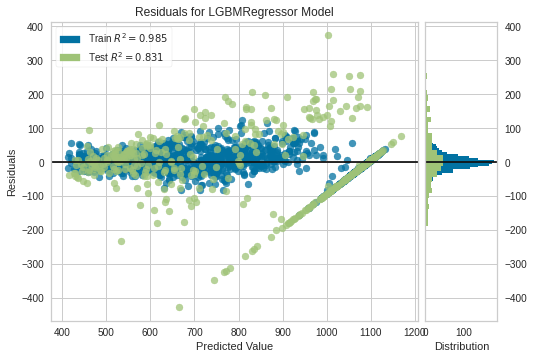

In [29]:
plot_model(best_models_5[0], "residuals")

На графике невязок мы можем заметить четкий паттерн - линия.  
Это связано с тем, что у меток временных рядов есть верхняя граница - 1093.  
Эта метка ставится тогда, когда уставка будет достигнута через очень долгое время, а значит метки 1093 и, например, 1092 различаются всего на 1 временной промежуток, но в реальности это могут быть сотни или тысячи промежутков.  
Это значительно сказывается на интерпретации признаков.  

predicted
1093         0.338095
dtype: float64

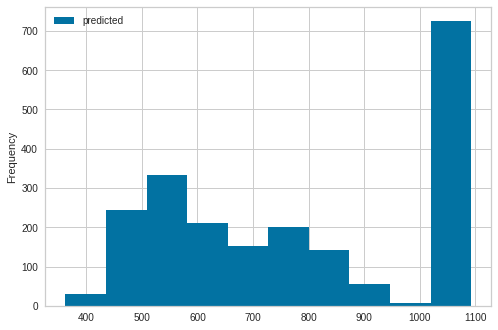

In [35]:
train_labels.plot(kind="hist")
train_labels.value_counts()[1093] / len(train_labels)

При этом, значение `1093` - самое часто встречающееся (**33%** всех измерений)  
Чтобы решить такую проблему, разобьем обучающее множество на две части:
* 1093
* <1093

Тогда решение будет состоять из 2 частей: классификация и регрессия.

# Классификация

In [36]:
cl_main_df = main_df.copy()
cl_main_df.label = cl_main_df.label.where(main_df.label==1093,0)
cl_main_df

,mean_h2,mean_co,mean_c2h4,mean_c2h2,max_h2,max_co,max_c2h4,max_c2h2,std_h2,std_co,...,highest_end_label,diff_h2,diff_co,diff_c2h4,diff_c2h2,h2_p,co_p,c2h4_p,c2h2_p,label
name,,,,,,,,,,,,,,,,,,,,,
2_trans_100.csv,0.00258966,0.0164906,0.00287593,0.000335897,0.00304159,0.0212994,0.00379544,0.000463635,0.000148275,0.00146231,...,CO,0.00346555,0.0537642,0.00755924,0.00125753,0.106349,0.744733,0.132707,0.016211,0
2_trans_1000.csv,0.0028248,0.0147277,0.00199181,0.000339416,0.00400243,0.0284454,0.00302025,0.000392744,0.00049976,0.00575373,...,CO,0.00926019,0.0989701,0.00783239,0.000413755,0.11161,0.793217,0.0842214,0.0109519,0
2_trans_1001.csv,0.00276375,0.01703,0.0033941,0.000195386,0.00376711,0.0273401,0.00464643,0.000312188,0.00033922,0.00338089,...,CO,0.0108357,0.121694,0.0142727,0.00148832,0.104451,0.758061,0.128832,0.00865606,0
2_trans_1002.csv,0.000507666,0.0163336,0.00410434,0.00037994,0.0010752,0.0233492,0.00611284,0.000528606,0.000187243,0.00220253,...,CO,0.00566103,0.0809505,0.0214751,0.00131953,0.0346104,0.751604,0.19677,0.0170156,0
2_trans_1006.csv,0.0026543,0.0212782,0.00406766,0.000123984,0.00285852,0.0252133,0.00682403,0.000204139,8.4182e-05,0.00155789,...,CO,0.00568446,0.0451104,0.02524,0.00104824,0.0814393,0.718328,0.194417,0.00581593,1093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_trans_993.csv,0.00254859,0.00946007,0.00746469,0.000241872,0.00301702,0.0269602,0.00985221,0.000347922,0.000150335,0.00728785,...,CO,0.00436374,0.108193,0.0219698,0.000924552,0.0750926,0.67103,0.245218,0.00865964,1093
2_trans_994.csv,0.000915423,0.00577034,0.00722967,8.09984e-05,0.00182681,0.00774959,0.00813938,0.000166969,0.000331333,0.000739649,...,C2H4,0.00832459,0.0278578,0.00934719,0.000683221,0.102155,0.433356,0.455153,0.00933687,1093
2_trans_995.csv,0.00156541,0.0024923,0.00852926,0.000175879,0.00328079,0.00419025,0.0099488,0.000199072,0.000727811,0.000477038,...,C2H4,0.0120791,0.0335025,0.0175092,0.000395431,0.186209,0.237827,0.564666,0.0112987,0


In [37]:
import pycaret.classification as pcl

In [38]:
first_step = pcl.setup(cl_main_df,
           target="label",
           n_jobs=2,
           train_size=0.8,
           data_split_shuffle=True,
          )

,Description,Value
0,session_id,2845
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1093: 1"
4,Original Data,"(2100, 33)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [39]:
best_models_5_class = pcl.compare_models(fold=10, n_select=5, exclude = ["catboost"])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8875,0.9529,0.8228,0.8435,0.8318,0.7474,0.7487,0.2370
lightgbm,Light Gradient Boosting Machine,0.8863,0.9541,0.8368,0.8309,0.8331,0.7470,0.7477,0.0790
gbc,Gradient Boosting Classifier,0.8851,0.9503,0.8228,0.8375,0.8293,0.7428,0.7437,0.4700
rf,Random Forest Classifier,0.8780,0.9478,0.7754,0.8538,0.8115,0.7217,0.7247,0.4920
et,Extra Trees Classifier,0.8768,0.9477,0.7544,0.8674,0.8051,0.7159,0.7211,0.4250
ada,Ada Boost Classifier,0.8482,0.9302,0.7982,0.7661,0.7811,0.6651,0.6662,0.1290
dt,Decision Tree Classifier,0.8107,0.7940,0.7421,0.7130,0.7262,0.5818,0.5832,0.0210
lda,Linear Discriminant Analysis,0.8042,0.8827,0.6702,0.7335,0.6994,0.5547,0.5568,0.0210
qda,Quadratic Discriminant Analysis,0.7030,0.7438,0.3561,0.5869,0.3934,0.2452,0.2693,0.0180
ridge,Ridge Classifier,0.6887,0.0000,0.1474,0.6978,0.2420,0.1409,0.2090,0.0190


В задаче классификации мы можем достичь примерно 90% точности используя тюнинг и stack моделей.

# Регрессия

In [43]:
reg_main_df = main_df.copy()
reg_main_df.label = reg_main_df.label.where(main_df.label!=1093)
reg_main_df = reg_main_df.dropna(axis=0)

In [44]:
reg = setup(reg_main_df,
           target="label",
           n_jobs=2,
           train_size=0.8,
           data_split_shuffle=True,
          )

,Description,Value
0,session_id,7402
1,Target,label
2,Original Data,"(1390, 33)"
3,Missing Values,False
4,Numeric Features,31
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1112, 30)"


In [46]:
best_models_5_reg = compare_models(fold=10, n_select=5, exclude = ["catboost"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,52.0532,5034.8054,70.6435,0.7497,0.1002,0.0776,0.0980
rf,Random Forest Regressor,52.4160,5225.5450,72.0013,0.7409,0.1014,0.0776,0.7490
et,Extra Trees Regressor,54.8871,5380.3506,72.9454,0.7333,0.1026,0.0820,0.4490
xgboost,Extreme Gradient Boosting,56.6877,5931.3093,76.7304,0.7068,0.1095,0.0848,0.4390
gbr,Gradient Boosting Regressor,60.5368,6201.9899,78.3615,0.6926,0.1127,0.0922,0.3640
ada,AdaBoost Regressor,80.4380,9351.1503,96.5462,0.5315,0.1479,0.1315,0.1230
dt,Decision Tree Regressor,70.7545,9882.0752,99.1050,0.5035,0.1410,0.1046,0.0170
lr,Linear Regression,99.2088,16380.1191,126.8675,0.1829,0.1874,0.1573,0.0110
omp,Orthogonal Matching Pursuit,108.2760,17251.1371,131.0836,0.1410,0.1996,0.1727,0.0110
ridge,Ridge Regression,120.5271,20023.2127,141.2930,0.0042,0.2161,0.1929,0.0180


На таком обучающем множестве без 1093 мы имеем результаты значительно лучшие, относительно предыдущей модели.

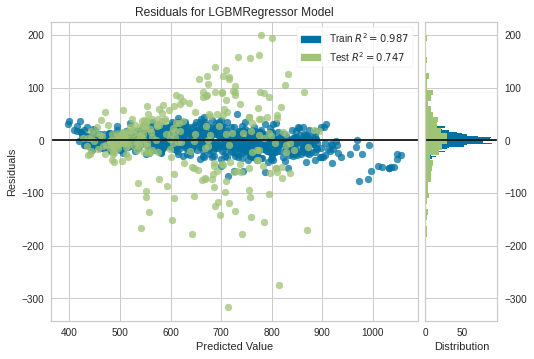

In [47]:
plot_model(best_models_5_reg[0], "residuals")

И на графике невязок уже незаметно таких четких паттернов.  

После объединения классификации и регрессии наша лучшая попытка показала `MAE ~ 55`.  
Таким образом мы обеспечили себе первое место в соревновании ([kaggle](https://www.kaggle.com/c/transformer-time/leaderboard)).
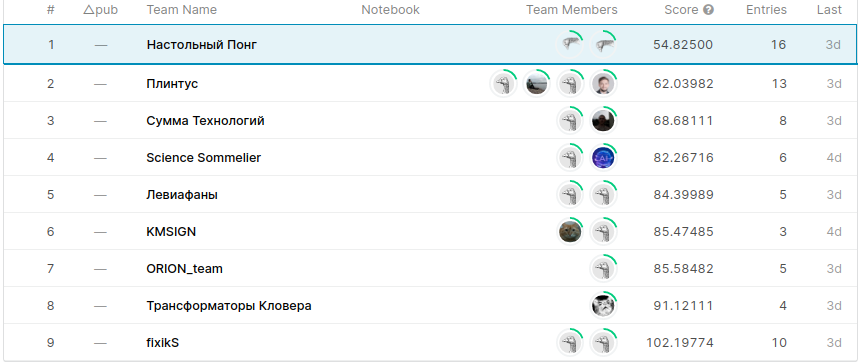